#Importing libraries and DATA

In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data=pd.read_csv('classification.csv')
x = np.array(data)
np.random.shuffle(x)
train , test = x[:220,:], x[220:,:]
xtrain, y_train = train[:,0:2], train[:,2]
xtest, y_test = test[:,0:2] , test[:,2]

In [25]:
m = np.mean(xtrain)
stded = np.std(xtrain)
x_train = (xtrain - m ) / stded
x_test = (xtest - m) / stded

# Neural Network from Scratch using ReLU

In [26]:
# add comments to explain the code
import math
import numpy as np


def sigmoidScalar(x): #  sigmoid function
    return 1/(1+math.exp(-x))

def sigmoidPriScal(x): # derivative of sigmoid function
    return sigmoidScalar(x)*(1-sigmoidScalar(x)) 

def reluScalar(x): # ReLU function
    if x > 0:
        return x
    else:
        return 0


def reluPriScal(x): # derivative of ReLU function
    if x > 0:
        return 1
    else:
        return 0

def tanhScalar(x): # tanh function
    return math.tanh(x)

def tanhPriScal(x): # derivative of tanh function
    return 1 - math.tanh(x)**2



sigmoid = np.vectorize(sigmoidScalar) # vectorize sigmoid function
sigmoidPrime = np.vectorize(sigmoidPriScal) # vectorize derivative of sigmoid function
relu = np.vectorize(reluScalar) # vectorize ReLU function
reluPrime = np.vectorize(reluPriScal) # vectorize derivative of ReLU function
tanh = np.vectorize(tanhScalar) # vectorize tanh function
tanhPrime = np.vectorize(tanhPriScal) # vectorize derivative of tanh function

In [27]:
class NeuralNetwork: # class for neural network
    def __init__(self, X, Y, dims, lr=1.2, iterations=3000): # constructor
        self.X = X # input
        self.Y = Y # output
        self.dims = dims # dimensions of the network
        self.lr = lr  # learning rate
        self.iterations = iterations # number of iterations
        self.length = len(self.dims)-1 # length of the network
        self.parameters = {} # parameters of the network
        self.cache = {} # cache of the network
        self.grads = {} # gradients of the network
        self.cost = 1   # cost of the network
        self.train_acc = [] # training accuracy of the network
        self.cost_list = [] # cost list of the network

    def initialize(self): # initialize parameters of the network
        np.random.seed(3) # set seed for random number generation 
        for l in range(1, len(self.dims)): # for each layer
            self.parameters['W'+str(l)] = np.random.randn(self.dims[l],
                                                      self.dims[l-1])*0.01 # initialize weights
            self.parameters['b'+str(l)] = np.zeros((self.dims[l], 1)) # initialize biases
    
    def predict(self, X): # predict the output of the network
        self.forward_propagation() # forward propagation
        return np.round(self.cache['A'+str(len(self.dims)-1)]) # return the output

    def forward_propagation(self): # forward propagation
        self.cache['A0'] = self.X # input layer
        # For last layer, ie, the output layer 3, we need to activate using sigmoid
        # For layer 1 and 2, we need to use relu
        for l in range(1, len(self.dims)-1): # for each layer
            self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                            self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # compute Z
            self.cache['A'+str(l)] = relu(self.cache['Z'+str(l)]) # compute A
        l = len(self.dims)-1    # for the last layer                    
        self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                        self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # compute Z
        self.cache['A'+str(l)] = sigmoid(self.cache['Z'+str(l)]) # compute A

    def compute_cost(self): # compute cost of the network
        m = self.Y.shape[0] # number of training examples
        A = self.cache['A'+str(len(self.dims)-1)] # output of the network
        self.cost = -1/m * \
            np.sum(np.multiply(self.Y, np.log(A)) +
                   np.multiply(1-self.Y, np.log(1-A))) # cost function
        self.cost = np.squeeze(self.cost) # remove the extra dimension

    def backward_propagation(self): # backward propagation
        A = self.cache['A' + str(len(self.dims) - 1)] # output of the network
        m = self.X.shape[1] # number of training examples
        self.grads['dA'+str(len(self.dims)-1) 
                   ] = np.divide(A - self.Y, (1 - A) * A) # compute dA
        # Sigmoid derivative for final layer
        l = len(self.dims)-1 # for the last layer
        self.grads['dZ' + str(l)] = self.grads['dA' + str(l)] * \
            sigmoidPrime(self.cache['Z' + str(l)]) # compute dZ
        self.grads['dW' + str(l)] = 1 / m * np.dot(self.grads['dZ' +
                                                              str(l)], self.cache['A' + str(l - 1)].T) # compute dW
        self.grads['db' + str(l)] = 1 / m * \
            np.sum(self.grads['dZ' + str(l)], axis=1, keepdims=True) # compute db
        self.grads['dA' + str(l - 1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ' + str(l)]) # compute dA
        # Relu derivative for previous layers
        for l in range(len(self.dims)-2, 0, -1): # for each layer
            self.grads['dZ'+str(l)] = self.grads['dA'+str(l)] * \
                reluPrime(self.cache['Z'+str(l)]) # compute dZ
            self.grads['dW'+str(l)] = 1/m*np.dot(self.grads['dZ' +
                                                            str(l)], self.cache['A'+str(l-1)].T) # compute dW
            self.grads['db'+str(l)] = 1/m * \
                np.sum(self.grads['dZ'+str(l)], axis=1, keepdims=True) # compute db
            self.grads['dA'+str(l-1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ'+str(l)]) # compute dA

    def update_parameters(self): # update parameters of the network
        for l in range(1, len(self.dims)): # for each layer
            self.parameters['W'+str(l)] = self.parameters['W'+str(l)] - \
                self.lr*self.grads['dW'+str(l)] # update W
            self.parameters['b'+str(l)] = self.parameters['b'+str(l)] - \
                self.lr*self.grads['db'+str(l)] # update b

    def train(self):    # train the network
        np.random.seed(1)   # set seed for random number generation
        self.initialize()   # initialize parameters
        for i in range(self.iterations):   # for each iteration
            self.forward_propagation() # forward propagation
            self.compute_cost() # compute cost
            self.backward_propagation() # backward propagation
            self.update_parameters() # update parameters
            if i % 100 == 0: # every 100 iterations
                print('Cost after {} iterations is {}'.format(i, self.cost))    # print cost
                # calculate prediction and accuracy for training set and append to list
                pred = self.predict(self.X) # predict the output of the network
                acc = np.sum(pred == self.Y) / self.Y.shape[0] # calculate accuracy
                self.train_acc.append(acc) # append accuracy to list
                # calculate cost for each iteration and append to list
                self.cost_list.append(self.cost) # append cost to list
        print('Final cost is {}'.format(self.cost)) # print final cost

## Neural Network using ReLU with 1 hidden layer

In [28]:
import numpy as np # import numpy
clf = NeuralNetwork(x_train.T, y_train, [2, 32, 1], lr=1, iterations=4200) # create a neural network
clf.train() # train the network

Cost after 0 iterations is 0.6931471805599453
Cost after 100 iterations is 0.34318680400044327
Cost after 200 iterations is 0.3016760748015565
Cost after 300 iterations is 0.30102581456760896
Cost after 400 iterations is 0.2932708110579799
Cost after 500 iterations is 0.29769329770579467
Cost after 600 iterations is 0.2999835390936028
Cost after 700 iterations is 0.3045374123565686
Cost after 800 iterations is 0.31430992019499837
Cost after 900 iterations is 0.3103960138290979
Cost after 1000 iterations is 0.3068830606323699
Cost after 1100 iterations is 0.30708957221862354
Cost after 1200 iterations is 0.3062338585142053
Cost after 1300 iterations is 0.30204447875456875
Cost after 1400 iterations is 0.29875677105549775
Cost after 1500 iterations is 0.29817350084320215
Cost after 1600 iterations is 0.29892912927057386
Cost after 1700 iterations is 0.2989772335459698
Cost after 1800 iterations is 0.2963252925699922
Cost after 1900 iterations is 0.2959876242571556
Cost after 2000 iterati

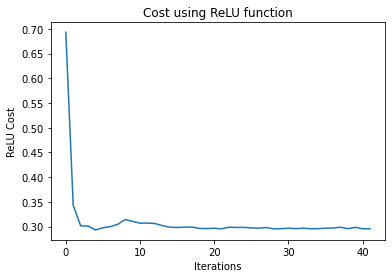

In [29]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using ReLU function') # set title
plt.xlabel('Iterations') # set x label
plt.ylabel('ReLU Cost') # set y label
plt.show() # show plot

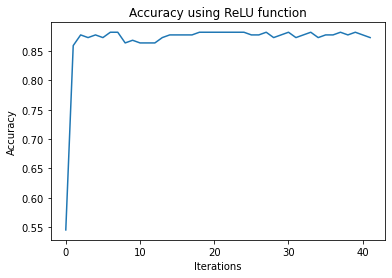

In [30]:
# plot accuracy vs iterations
plt.plot(clf.train_acc) # plot accuracy vs iterations
plt.title('Accuracy using ReLU function') # set title
plt.xlabel('Iterations') # set x label
plt.ylabel('Accuracy') # set y label
plt.show() # show plot

## Neural Network using ReLU with 2 hidden layers

In [31]:
import numpy as np # import numpy
clf = NeuralNetwork(x_train.T, y_train, [2, 32, 64,1], lr=1, iterations=4200) # create a neural network
clf.train() # train the network

Cost after 0 iterations is 0.6931471805599453
Cost after 100 iterations is 0.6890092384766585
Cost after 200 iterations is 0.6890092384766585
Cost after 300 iterations is 0.6890092384766585
Cost after 400 iterations is 0.6890092384766585
Cost after 500 iterations is 0.6890092384766585
Cost after 600 iterations is 0.6890092384766585
Cost after 700 iterations is 0.6890092384766585
Cost after 800 iterations is 0.6890092384766585
Cost after 900 iterations is 0.6890092384766585
Cost after 1000 iterations is 0.6890092384766585
Cost after 1100 iterations is 0.6890092384766585
Cost after 1200 iterations is 0.6890092384766585
Cost after 1300 iterations is 0.6890092384766585
Cost after 1400 iterations is 0.6890092384766585
Cost after 1500 iterations is 0.6890092384766585
Cost after 1600 iterations is 0.6890092384766585
Cost after 1700 iterations is 0.6890092384766585
Cost after 1800 iterations is 0.6890092384766585
Cost after 1900 iterations is 0.6890092384766585
Cost after 2000 iterations is 0.

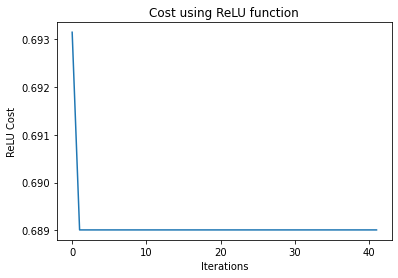

In [32]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using ReLU function') # set title
plt.xlabel('Iterations') # set x label
plt.ylabel('ReLU Cost') # set y label
plt.show() # show plot

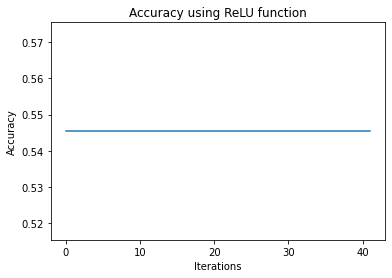

In [33]:
# plot accuracy vs iterations
plt.plot(clf.train_acc) # plot accuracy vs iterations
plt.title('Accuracy using ReLU function') # set title
plt.xlabel('Iterations') # set x label
plt.ylabel('Accuracy') # set y label
plt.show() # show plot

# Neural Network from Scratch using Tanh hypebolic

In [34]:
class NeuralNetwork: # neural network class
    def __init__(self, X, Y, dims, lr=1.2, iterations=3000): # initialize the network
        self.X = X # input data
        self.Y = Y  # output data
        # Including input layer and output layer. Let example be dims=4
        self.dims = dims # dimensions of the network
        self.lr = lr  # Learning rate
        self.iterations = iterations    # Number of iterations
        self.length = len(self.dims)-1 # length of the network
        self.parameters = {}    # To store parameters W and b for each layer
        self.cache = {}     # To store cache Z and A for each layer
        self.grads = {}     # To store dA, dZ, dW, db
        self.cost = 1       # Initial value does not matter
        self.train_acc = [] # To store training accuracy
        self.cost_list = [] # To store cost for each iteration

    def initialize(self):   # initialize parameters
        np.random.seed(3)   # set seed for random number generation
        for l in range(1, len(self.dims)):  # for each layer
            self.parameters['W'+str(l)] = np.random.randn(self.dims[l],
                                                      self.dims[l-1])*0.01  # initialize W
            self.parameters['b'+str(l)] = np.zeros((self.dims[l], 1))   # initialize b
    
    def predict(self, X):   # predict the output of the network
        self.forward_propagation()  # forward propagation
        return np.round(self.cache['A'+str(len(self.dims)-1)])  # return prediction

    def forward_propagation(self):  # forward propagation
        self.cache['A0'] = self.X   # set A0 to input data
        for l in range(1, len(self.dims)-1):    # for each layer
            self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                            self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)] # compute Z
            self.cache['A'+str(l)] = tanh(self.cache['Z'+str(l)])   # compute A
        l = len(self.dims)-1    # for last layer
        self.cache['Z'+str(l)] = np.dot(self.parameters['W'+str(l)],
                                        self.cache['A'+str(l-1)]) + self.parameters['b'+str(l)]     # compute Z
        self.cache['A'+str(l)] = sigmoid(self.cache['Z'+str(l)])    # compute A

    def compute_cost(self):  # compute cost
        m = self.Y.shape[0] # number of training examples
        A = self.cache['A'+str(len(self.dims)-1)]   # output of the network
        self.cost = -1/m * \
            np.sum(np.multiply(self.Y, np.log(A)) +
                   np.multiply(1-self.Y, np.log(1-A)))  # compute cost
        self.cost = np.squeeze(self.cost)   # remove dimensions of size 1

    def backward_propagation(self): # backward propagation
        A = self.cache['A' + str(len(self.dims) - 1)]   # output of the network
        m = self.X.shape[1]     # number of training examples
        self.grads['dA'+str(len(self.dims)-1)
                   ] = np.divide(A - self.Y, (1 - A) * A)   # compute dA
        # Sigmoid derivative for final layer
        l = len(self.dims)-1    # for last layer
        self.grads['dZ' + str(l)] = self.grads['dA' + str(l)] * \
            sigmoidPrime(self.cache['Z' + str(l)])  # compute dZ
        self.grads['dW' + str(l)] = 1 / m * np.dot(self.grads['dZ' +
                                                              str(l)], self.cache['A' + str(l - 1)].T)  # compute dW
        self.grads['db' + str(l)] = 1 / m * \
            np.sum(self.grads['dZ' + str(l)], axis=1, keepdims=True)        # compute db
        self.grads['dA' + str(l - 1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ' + str(l)])    # compute dA
        # tanh derivative for previous layers
        for l in range(len(self.dims)-2, 0, -1):    # for each layer
            self.grads['dZ'+str(l)] = self.grads['dA'+str(l)] * \
                tanhPrime(self.cache['Z'+str(l)])   # compute dZ
            self.grads['dW'+str(l)] = 1/m*np.dot(self.grads['dZ' +
                                                            str(l)], self.cache['A'+str(l-1)].T)    # compute dW
            self.grads['db'+str(l)] = 1/m * \
                np.sum(self.grads['dZ'+str(l)], axis=1, keepdims=True)  # compute db
            self.grads['dA'+str(l-1)] = np.dot(self.parameters['W' +
                                                           str(l)].T, self.grads['dZ'+str(l)])  # compute dA

    def update_parameters(self):    # update parameters
        for l in range(1, len(self.dims)):  # for each layer
            self.parameters['W'+str(l)] = self.parameters['W'+str(l)] - \
                self.lr*self.grads['dW'+str(l)]  # update W
            self.parameters['b'+str(l)] = self.parameters['b'+str(l)] - \
                self.lr*self.grads['db'+str(l)] # update b

    def train(self):    # train the network
        np.random.seed(1)   # set seed for random number generation
        self.initialize()   # initialize parameters
        for i in range(self.iterations):    # for each iteration
            self.forward_propagation()  # forward propagation
            self.compute_cost() # compute cost
            self.backward_propagation() # backward propagation
            self.update_parameters()    # update parameters
            if i % 100 == 0:    # print cost every 100 iterations
                print('Cost after {} iterations is {}'.format(i, self.cost))
                # calculate prediction and accuracy for training set and append to list
                pred = self.predict(self.X)
                acc = np.sum(pred == self.Y) / self.Y.shape[0]
                self.train_acc.append(acc)
                # calculate cost for each iteration and append to list
                self.cost_list.append(self.cost)
        print('Final cost is {}'.format(self.cost))

## Neural Network with Tanh using 4 hidden layers

In [35]:
import numpy as np # import numpy
clf = NeuralNetwork(x_train.T, y_train, [2, 128 , 64 , 64 ,32,1], lr=1, iterations=5000)    # create classifier
clf.train()   # train the classifier

Cost after 0 iterations is 0.6931470889300491
Cost after 100 iterations is 0.6890089328804229
Cost after 200 iterations is 0.6890086940306878
Cost after 300 iterations is 0.689008425613124
Cost after 400 iterations is 0.6890081107940126
Cost after 500 iterations is 0.6890077262445314
Cost after 600 iterations is 0.6890072375018537
Cost after 700 iterations is 0.6890065905477983
Cost after 800 iterations is 0.6890056953536006
Cost after 900 iterations is 0.6890043909546811
Cost after 1000 iterations is 0.6890023633738275
Cost after 1100 iterations is 0.6889989251064
Cost after 1200 iterations is 0.6889923002172395
Cost after 1300 iterations is 0.688976527356
Cost after 1400 iterations is 0.6889185462870061
Cost after 1500 iterations is 0.687719143570795
Cost after 1600 iterations is 0.30334638039293776
Cost after 1700 iterations is 0.3031958907935987
Cost after 1800 iterations is 0.3033378330843466
Cost after 1900 iterations is 0.3028750417230465
Cost after 2000 iterations is 0.30287007

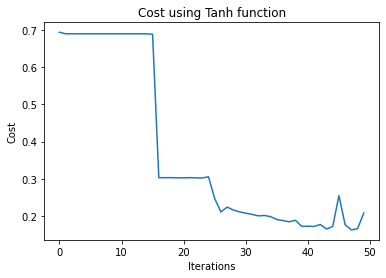

In [36]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using Tanh function')   # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Cost')  # y-axis label
plt.show()  # show plot

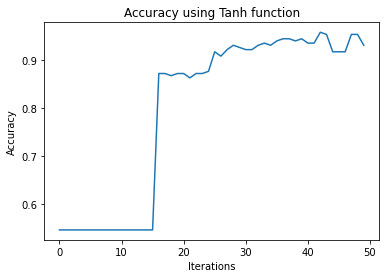

In [37]:
# plot accuracy vs iterations
plt.plot(clf.train_acc)     # plot accuracy vs iterations
plt.title('Accuracy using Tanh function')       # plot title

plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Accuracy')  # y-axis label
plt.show()  # show plot

## Neural Network with Tanh using 2 hidden layers

In [38]:
import numpy as np  # import numpy
clf = NeuralNetwork(x_train.T, y_train, [2, 64 ,32 ,1], lr=1, iterations=5000)  # create classifier
clf.train() # train the classifier

Cost after 0 iterations is 0.693132394584005
Cost after 100 iterations is 0.30270256964625963
Cost after 200 iterations is 0.30262618573601374
Cost after 300 iterations is 0.30256267931630987
Cost after 400 iterations is 0.30249624207645387
Cost after 500 iterations is 0.3023703592196205
Cost after 600 iterations is 0.3014708404475311
Cost after 700 iterations is 0.27936849279070236
Cost after 800 iterations is 0.2472044872243304
Cost after 900 iterations is 0.21988123169706428
Cost after 1000 iterations is 0.432792955241273
Cost after 1100 iterations is 0.2168153156933317
Cost after 1200 iterations is 0.2031978208302567
Cost after 1300 iterations is 0.19836985875792504
Cost after 1400 iterations is 0.19386739505748699
Cost after 1500 iterations is 0.20182823110604955
Cost after 1600 iterations is 0.19001041119537557
Cost after 1700 iterations is 0.18823067497019672
Cost after 1800 iterations is 0.1851100121269779
Cost after 1900 iterations is 0.18137497147443624
Cost after 2000 iterat

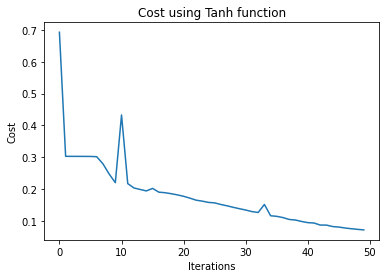

In [39]:
# plot cost vs iterations   
import matplotlib.pyplot as plt # import matplotlib
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using Tanh function')   # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Cost')  # y-axis label
plt.show()  # show plot

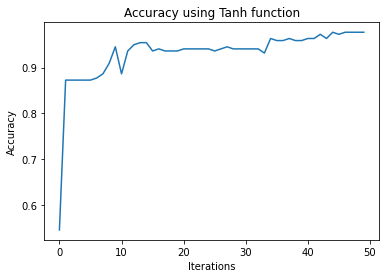

In [40]:
# plot accuracy vs iterations
plt.plot(clf.train_acc)    # plot accuracy vs iterations
plt.title('Accuracy using Tanh function')    # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Accuracy')  # y-axis label
plt.show()  # show plot

## Neural Network with Tanh using 1 hidden layers

In [41]:
import numpy as np  # import numpy  
clf = NeuralNetwork(x_train.T, y_train, [2, 32 ,1], lr=1, iterations=5000)  # create classifier
clf.train() # train the classifier

Cost after 0 iterations is 0.6932230536008903
Cost after 100 iterations is 0.30243637173034127
Cost after 200 iterations is 0.3023686306719184
Cost after 300 iterations is 0.3021951679118183
Cost after 400 iterations is 0.3011187152878839
Cost after 500 iterations is 0.2938062090479451
Cost after 600 iterations is 0.2695604088066718
Cost after 700 iterations is 0.24492876911285838
Cost after 800 iterations is 0.23125025750016887
Cost after 900 iterations is 0.22359258572719573
Cost after 1000 iterations is 0.21887250924264628
Cost after 1100 iterations is 0.21570523205882017
Cost after 1200 iterations is 0.21338145897287633
Cost after 1300 iterations is 0.2115140611725698
Cost after 1400 iterations is 0.20988077957199022
Cost after 1500 iterations is 0.20833434357406813
Cost after 1600 iterations is 0.20674707342577325
Cost after 1700 iterations is 0.20498067979781995
Cost after 1800 iterations is 0.20289284097764923
Cost after 1900 iterations is 0.20040086638846422
Cost after 2000 ite

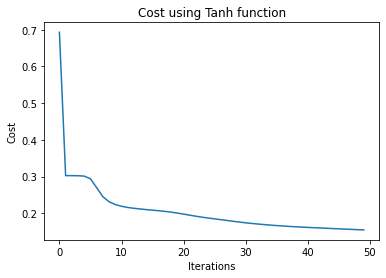

In [42]:
# plot cost vs iterations
import matplotlib.pyplot as plt # import matplotlib 
plt.plot(clf.cost_list) # plot cost vs iterations
plt.title('Cost using Tanh function')   # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Cost')  # y-axis label
plt.show()  # show plot

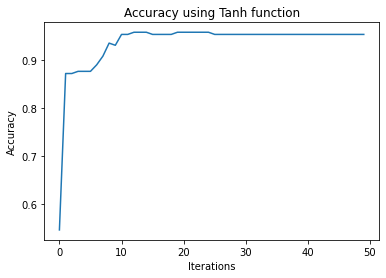

In [43]:
# plot accuracy vs iterations
plt.plot(clf.train_acc)   # plot accuracy vs iterations
plt.title('Accuracy using Tanh function')   # plot title
plt.xlabel('Iterations')    # x-axis label
plt.ylabel('Accuracy')      # y-axis label
plt.show()  # show plot